In [1]:
import torch
from tqdm.auto import tqdm
from optree import tree_map_
import pickle
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True)
num_data = len(train_dataloader.dataset)

In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Turn off Dropout
model.eval()

# Move to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

In [5]:
# Train using SGHMC
sampler = uqlib.sgmcmc.optim.SGHMC(
    model.parameters(), lr=1e-3, alpha=1e-6, maximize=True
)

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)

progress_bar = tqdm(range(num_training_steps))

log_posts = []

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        log_post = param_to_log_posterior(dict(model.named_parameters()), batch)

        log_post.backward()
        log_posts.append(log_post.item())
        
        print(log_posts[-1], end='\r')

        sampler.step()
        sampler.zero_grad()
        progress_bar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

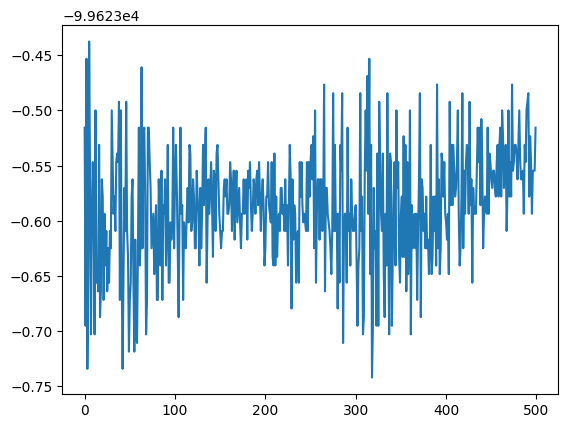

In [6]:
plt.plot(log_posts);